In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from math import pi, tanh

def complex_to_rgb(c: torch.Tensor):
    hue = c.angle().item() / (2 * pi)
    saturation = 1
    light = 0.9-0.8*tanh(c.abs().item())
    return colorsys.hls_to_rgb(hue, light, saturation)

In [ ]:
# leggo l'immagine
image_path = 'db/cutted_set/Author1/Author1_0025_02.png'

# carico l'immagine e la passo a torch
image = Image.open(image_path).convert('L')
image_torch = torch.from_numpy(np.array(image)).to('cuda')
image_torch_mean = image_torch.mean(dtype=torch.float32)
image_torch = image_torch - image_torch_mean
image_torch = image_torch / image_torch.var()**0.5

# analisi di fourier usando fft2d
image_fft = torch.fft.fft2(image_torch, norm='ortho').to('cpu')

# devo ideare una scala di colore che dato un numero complesso mi dia un colore
image_fft_rgb = torch.zeros(image_fft.shape + (3,))
for i in range(image_fft.shape[0]):
    for j in range(image_fft.shape[1]):
        image_fft_rgb[i, j] = torch.tensor(complex_to_rgb(image_fft[i, j]))

# visualizzo le due immagini a confronto in una grande figura
plt.figure(figsize=(2*8, 1*8))
plt.subplot(1, 2, 1)
plt.imshow(image_torch.to('cpu'), cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(image_fft_rgb.to('cpu'), vmin=0, vmax=1)
plt.axis('off')
plt.title('Fourier Transform')
plt.savefig('fft.png', dpi=600)

In [ ]:
# rilevo i picchi di magnitudine
p = 0.1/100  # percentile
image_fft_abs = image_fft.flatten().abs()
image_fft_abs_sort = torch.sort(image_fft_abs, descending=True)
threshold = image_fft_abs_sort.values[int(p * image_fft_abs.numel())]
image_fft_abs_thresholded = image_fft_abs <= threshold

# cambio tipo in float
image_fft_abs_thresholded = image_fft_abs_thresholded.to(torch.float32)

# visualizzo i picchi
plt.figure()
plt.imshow(image_fft_abs_thresholded.reshape(image_fft.shape), cmap='gray')
plt.axis('off')
plt.title(f'Peaks using percentile {p*100:.2f}%')

In [ ]:
# annullo i picchi
image_fft_new = image_fft * image_fft_abs_thresholded.reshape(image_fft.shape)

# ricostruisco l'immagine
image_reconstructed = torch.fft.ifft2(image_fft_new, norm='ortho').real
image_reconstructed = (image_reconstructed - image_reconstructed.min()) / (image_reconstructed.max() - image_reconstructed.min())

# visualizzo l'immagine ricostruita
plt.figure()
plt.imshow(image_reconstructed, cmap='gray')
plt.axis('off')
plt.title('Reconstructed Image with percentile threshold 0.02%')
plt.savefig('reconstructed.png', dpi=600)

In [ ]:
# mostro l'istogramma dei valori di grigio di image_torch
plt.figure()
image_reconstructed = (image_reconstructed - image_reconstructed.min()) / (image_reconstructed.max() - image_reconstructed.min())
plt.subplot(1,2,1)
plt.hist(image_reconstructed.to('cpu').flatten(), bins=256, density=True)
plt.title('Reconstructed Image Histogram')
plt.xlabel('Gray Value')
plt.ylabel('Density')
#plt.subplot(1,2,1)
plt.subplot(1,2,2)
image_normalized = (np.array(image) - np.array(image).min()) / (np.array(image).max() - np.array(image).min())
plt.hist(image_normalized.flatten(), bins=256, density=True)
plt.title('Original Image Histogram')
plt.xlabel('Gray Value')
plt.savefig("diagrams.png", dpi=600)


In [ ]:
# imposto un threshold e mostro nell'immagine quali pixel superano il threshold
min,max = 0.2, 0.8
image_torch = torch.from_numpy(np.array(image)) / 255.0
# bianco qui -> bianco originale (dello sfondo) allora ok
plt.figure(figsize=(20, 10))
plt.imshow(image_torch > max, cmap='gray')
plt.axis('off')
plt.title('Thresholded Image')
# nero qui -> nero originale (delle scritte) allora ok
plt.figure(figsize=(20, 10))
plt.imshow(image_torch >= min, cmap='gray')
plt.axis('off')
plt.title('Thresholded Image')

In [ ]:
# mostro nel diagramma i valori di grigio dell'immagine originale evidenziando in rosso quelli inferiori a min e in verde quelli superiori a max
plt.subplot(1,2,1)
plt.hist(image_torch.flatten(), bins=256, density=True)
plt.title('Original Image Histogram')
plt.xlabel('Gray Value')
plt.ylabel('Density')
plt.axvline(min, color='red', label='Handwriting threshold')
plt.axvline(max, color='green', label='Background threshold')
plt.legend()
plt.subplot(1,2,2)
# conto quanti pixel in image_torch sono inferiori a min
b_cnt = torch.count_nonzero(image_torch <= min) / image_torch.numel()
# conto quanti pixel in image_torch sono superiori a max
w_cnt = torch.count_nonzero(image_torch >= max) / image_torch.numel()
# determino i trashold per il clamp
h_b = torch.quantile(image_reconstructed, b_cnt)
h_w = torch.quantile(image_reconstructed, 1 - w_cnt)
plt.hist(image_reconstructed.flatten(), bins=256, density=True)
plt.title('Original Image Histogram')
plt.xlabel('Gray Value')
plt.ylabel('Density')
plt.axvline(h_b, color='red', label='Handwriting threshold')
plt.axvline(h_w, color='green', label='Background threshold')
plt.legend()
plt.savefig('thresholded_histogram.png', dpi=600)

In [ ]:
# normalize image
min,max = 0.2, 0.8
# conto quanti pixel in image_torch sono inferiori a min
b_cnt = torch.count_nonzero(image_torch <= min) / image_torch.numel()
# conto quanti pixel in image_torch sono superiori a max
w_cnt = torch.count_nonzero(image_torch >= max) / image_torch.numel()
# determino i trashold per il clamp
h_b = torch.quantile(image_reconstructed, b_cnt)
h_w = torch.quantile(image_reconstructed, 1 - w_cnt)


image_new = (image_reconstructed - h_b) / (h_w - h_b)
image_new = torch.clamp(image_new, 0, 1)

In [ ]:

# visualizzo l'immagine ricostruita
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(image_reconstructed, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Reconstructed Image without normalisation')

# mostro il plot dei grigi presenti
plt.subplot(2, 2, 2, aspect=0.05)
plt.hist(image_reconstructed.flatten(), bins=256, density=True)
plt.title('Grayscale density')

plt.subplot(2, 2, 3)
plt.imshow(image_new, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title('Reconstructed Image with normalisation')
plt.subplot(2, 2, 4, aspect=0.003)
plt.hist(image_new.flatten(), bins=256, density=True)
plt.title('Grayscale density')

plt.savefig('first_reconstruct.png', dpi=1200)

In [6]:
import numpy

# load synthesis image
synth_path = r'.out/synthetized/Author2/Author2_0003_01.png'

with open(synth_path, "br") as f:
    values = f.read()
synth_1 = (
    numpy.frombuffer(values, dtype=numpy.uint8)
    .reshape(-1, 4 * 4)
    .astype(numpy.float32)
    / 255.0
)

In [9]:
# apply a PCA to the image
import sklearn.decomposition
import sklearn.manifold

pca = sklearn.decomposition.PCA(n_components=6)
pca.fit(synth_1)
synth_1_pca = pca.transform(synth_1)
indices = numpy.random.choice(synth_1_pca.shape[0], 10_000, replace=False)
synth_1_sample = synth_1_pca[indices]
#tsne = sklearn.manifold.TSNE(n_components=3, verbose=1, max_iter=3000, n_jobs=8)
#synth_1_tsne = tsne.fit_transform(synth_1_sample)
synth_1_tsne = synth_1_sample.copy()

In [13]:
# plot 3d of data
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.colors as mcolors

# load the data into a pandas dataframe
# data_3d = np.load('/home/stefano/Desktop/ao.npy')

data = synth_1_tsne.copy()
df = pd.DataFrame(data[:,:3], columns=['x', 'y', 'z'])

# nel data frame scrivo anche a quale indice appartiene il dato
df['Index'] = indices

# assegno un colore in base le 
df['r'] = data[:, 3]
df['g'] = data[:, 4]
df['b'] = data[:, 5]
# normalizzo tra 0,1
df['r'] = (df['r'] - df['r'].min()) / (df['r'].max() - df['r'].min())
df['g'] = (df['g'] - df['g'].min()) / (df['g'].max() - df['g'].min())
df['b'] = (df['b'] - df['b'].min()) / (df['b'].max() - df['b'].min())
# ottengo RGB da r,g,b
df['color'] = df.apply(lambda x: [x['r'], x['g'], x['b']], axis=1)

df['color_hex'] = df['color'].apply(mcolors.rgb2hex)

# quando la freccia si posa su un punto voglio che si mostri anche il campo 'Index' del dataframe
fig = px.scatter_3d(
    df, 
    x='x', 
    y='y', 
    z='z',
    opacity=1.0,
    width=1000,  # Imposta la larghezza del grafico
    height=800,  # Imposta l'altezza del grafico
    hover_data=['color_hex', 'Index'],  # Mostra l'indice del punto quando ci si posa sopra
)

fig.update_traces(marker=dict(color=df['color_hex'], size=5))

# Mostra il grafico interattivo
fig.show()

In [ ]:
from matplotlib import pyplot as plt
# plot 2d of an image
index = 3222433

# load the tile
tile = synth_1[index].reshape(4, 4)

# plot the tile
plt.figure()
plt.imshow(tile, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.savefig('tile.png', dpi=600)

# RESULTS EXPLORATION

In [7]:
# definisco una funzione che data path detecta l'autore
import os
def author_detect(path:str):
    # l'autore è il nome della cartella contenente il file
    author = os.path.basename(os.path.dirname(path))
    return author

# carico il file csv distances.csv
import pandas as pd
import numpy
from matplotlib import pyplot as plt

# il file csv è una matrice di float con righe e colonne indicizzate con una path
df = pd.read_csv('distances.csv', index_col=0)

distances = df.to_numpy()

# creo una tabella dove inserisco i risultati:
# la riga dell'autore i-esimo e la colonna dell'autore j-esimo contiene il numero di opere di i che sono state classificate come opere di j

# creo una lista di autori
authors = df.index.map(author_detect).unique()

# creo una tabella vuota
table = pd.DataFrame(numpy.zeros((len(authors), len(authors))), index=authors, columns=authors)

deep = 1
for i in range(len(df)):
    # estraggo le distanze della i-esima opera
    work_distances = distances[i].copy()
    # trasformo i nan in inf
    work_distances = numpy.nan_to_num(work_distances, nan=float('inf'))
    # trasformo il confronto con se stesso in inf
    work_distances[i] = float('inf')
    # trovo l'indice delle deep opere più vicine
    nearest_work = numpy.argpartition(work_distances, deep)[:deep]
    
    # per ogni autore conto il numero di opere in questa lista
    # vettore di infiniti
    score = numpy.full(len(authors), numpy.inf)
    counter = numpy.zeros(len(authors))
    for j in range(deep):
        # ricavo l'autore dell'opera di indice nearest_work[j]
        nearest_author = author_detect(df.index[nearest_work[j]])
        # incremento lo score con la distanza
        # se ho infinito annullo
        if score[authors.get_loc(nearest_author)] == numpy.inf:
            score[authors.get_loc(nearest_author)] = 0
        score[authors.get_loc(nearest_author)] += distances[i, nearest_work[j]]
        # incremento il contatore
        counter[authors.get_loc(nearest_author)] += 1
    
    # ricavo l'autore dell'opera stessa
    author = author_detect(df.index[i])
    # trovo l'autore dell'opera più vicina
    score = score / counter
    nearest_author = authors[score.argmin()]
    # incremento il contatore dell'autore i-esimo e dell'autore più vicino con il rapporto del numero di opere considerate
    # per l'opera i-esima conto il numero di opere che sono state comparate (non sono inf o nan)
    num_of_works = numpy.count_nonzero(work_distances != numpy.inf)
    table.at[author, nearest_author] += 1 #- 1 / num_of_works

print(table)

# per ogni autore calcolo i veri positivi e i veri negativi
for i in range(len(authors)):
    fp = 1 - table.iat[i, i] / table.iloc[:, i].sum()
    fn = 1 - table.iat[i, i] / table.iloc[i].sum()
    print('')
    print(f'Author {authors[i]}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    p = (table.iloc[i, :] / table.iloc[i, :].sum()).values
    p = p[p != 0]
    entropy = -numpy.log(p) @ p
    print(f'Entropy: {entropy} (max: {numpy.log(len(authors))*len(authors)})')

         Author2  Author4  Author1  Author3
Author2      2.0      2.0     37.0      2.0
Author4      0.0      9.0     37.0      5.0
Author1      6.0     47.0    195.0     22.0
Author3      0.0      3.0     42.0     11.0

Author Author2
False Positives: 0.75
False Negatives: 0.9534883720930233
Entropy: 0.5574130028750514 (max: 5.545177444479562)

Author Author4
False Positives: 0.8524590163934427
False Negatives: 0.8235294117647058
Entropy: 0.766606543978585 (max: 5.545177444479562)

Author Author1
False Positives: 0.37299035369774924
False Negatives: 0.2777777777777778
Entropy: 0.828254025703728 (max: 5.545177444479562)

Author Author3
False Positives: 0.725
False Negatives: 0.8035714285714286
Entropy: 0.6922301044014372 (max: 5.545177444479562)


# SVD

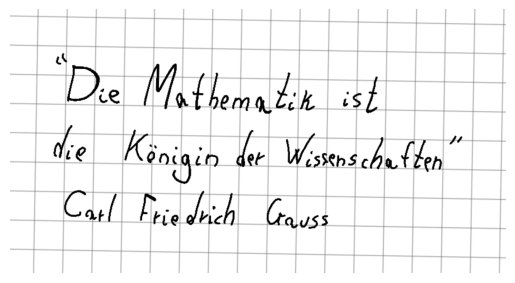

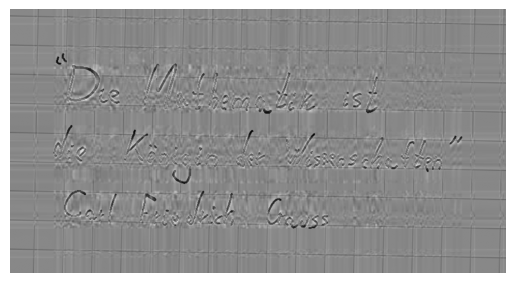

In [16]:
# carico l'immagine fraseGauss.png
from PIL import Image
import matplotlib.pyplot as plt

# converto in bit 0, 1
image = Image.open('fraseGauss_rotated.png').convert('L')
# aumento il contrasto
#image = image.point(lambda p: (p / 255)**5 * 255)
#image.save('fraseGauss.png')

plt.figure()
plt.imshow(image, cmap='gray', vmin=0, vmax=256)
plt.axis('off')
plt.show()

# uso SVD per comprimere l'immagine
import numpy as np

image_np = np.array(image)
U, S, V = np.linalg.svd(image_np, full_matrices=False)

# comprimo l'immagine
k=20
compressed_image = U[:, k:] @ np.diag(S[k:]) @ V[k:, :]
plt.figure()
plt.imshow(compressed_image, cmap='gray')
plt.axis('off')
plt.imsave('first_pattern.png', compressed_image, dpi=600, cmap='gray')
plt.show()
